In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [15]:
train_variants = pd.read_csv("data/training_variants")
test_variants = pd.read_csv("data/test_variants")

train_text = pd.read_csv("data/training_text", sep="\|\|", engine='python', header=None, skiprows=1,names=["ID","Text"])
test_text = pd.read_csv("data/test_text", sep="\|\|", engine='python', header=None, skiprows=1,names=["ID","Text"])

In [16]:
train = pd.merge(train_variants, train_text, how='left', on='ID')
train_y = train['Class'].values # Extract label as the expected output
train_x = train.drop('Class', axis=1) # Remove labels from the input

In [17]:
test_x = pd.merge(test_variants, test_text, how='left', on='ID')

In [18]:
print("Train variants\t",train_variants.shape)
print("Test variants\t",test_variants.shape)
print("Train text\t", train_text.shape)
print("Test text\t", test_text.shape)

Train variants	 (3321, 4)
Test variants	 (5668, 3)
Train text	 (3321, 2)
Test text	 (5668, 2)


### Concat for entire corpus

In [19]:
df_all = np.concatenate((train_x, test_x), axis=0)
df_all = pd.DataFrame(df_all) # DataFrame docs: https://pandas.pydata.org/pandas-docs/stable/api.html#dataframe
df_all.columns = ["ID", "Gene", "Variation", "Text"]
df_all.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


Using [TF IDF](http://scikit-larn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for vects

In [20]:
_sentences = df_all["Text"]
print(_sentences.shape)
_sentences[0][:2000]

(8989,)


'Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

In [126]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) #ideally
if 'sentence_vectors_ngram3.npy' in os.listdir('ckpt/'):
    print('using saved vectors')
    sentence_vectors =  np.load('ckpt/sentence_vectors_ngram3.npy').item(0)
#sentence_vectors1 = vectorizer.fit_transform(_sentences)

using saved vectors


In [27]:
#arr_sentence_vectors = np.load('ckpt/sentence_vectors_ngram3.npy')
#sentence_vectors = arr_sentence_vectors.item(0)

In [127]:
sentence_vectors.shape

(8989, 14699076)

(1,3):(8989, 14699076)\n
(1,2):(8989, 5245532)

* Use [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to reduce dimensionality. ( in Scikit like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), but here the values are not centered with the mean and SVD is more efficient as it operates directly on vals) 
* Currently Naive approach. Ideally check variance to guage.
* Memory Limitations

In [30]:
svd = TruncatedSVD(100) #Memory probs
sentence_vectors = svd.fit_transform(sentence_vectors)

In [31]:
print(sentence_vectors.shape)

(8989, 100)


In [32]:
import os
if 'ckpt' not in os.listdir():
    os.mkdir('ckpt')
np.save("ckpt/sentence_vectors_ngram2_100.npy", sentence_vectors)

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import regularizers
import pickle

Using TensorFlow backend.


In [98]:
def fully_connected_model():
    model = Sequential()
    model.add(Dense(128, input_shape=(100,), kernel_initializer='he_normal', activation='relu',))
    model.add(Dropout(0.6))
    model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(9, init='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [36]:
encoder = LabelEncoder()
encoder.fit(train_y) 
print(encoder.classes_) # Comes up with classes 1-9

encoded_y = encoder.transform(train_y) # Transforms training labels to 0-8
np.unique(encoded_y)

[1 2 3 4 5 6 7 8 9]


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [37]:
onehot_y = np_utils.to_categorical(encoded_y)
onehot_y.shape

(3321, 9)

In [38]:
train_sentence_vectors = sentence_vectors[0:len(train_x)]
print(train_sentence_vectors.shape)

(3321, 100)


In [66]:
num_epochs = 15

In [99]:
estimator = KerasClassifier(build_fn=fully_connected_model, epochs=num_epochs, batch_size=16)

In [41]:
#latest_model_filename = 'estimator_%d.sav' % num_epochs
#estimator = pickle.load(open(latest_model_filename, 'rb'))

In [102]:
history = estimator.fit(train_sentence_vectors, onehot_y, validation_split=0.1)

/home/xipher/.ml/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, activation="softmax", kernel_initializer="normal")`
  # This is added back by InteractiveShellApp.init_path()


Train on 2988 samples, validate on 333 samples
Epoch 1/15
2988/2988 [==============================] - 0s - loss: 1.9997 - acc: 0.2222 - val_loss: 1.8161 - val_acc: 0.4595
Epoch 2/15
2988/2988 [==============================] - 0s - loss: 1.8923 - acc: 0.2477 - val_loss: 1.7822 - val_acc: 0.4595
Epoch 3/15
2988/2988 [==============================] - 0s - loss: 1.8494 - acc: 0.2580 - val_loss: 1.7501 - val_acc: 0.4444
Epoch 4/15
2988/2988 [==============================] - 0s - loss: 1.8141 - acc: 0.2875 - val_loss: 1.6655 - val_acc: 0.4444
Epoch 5/15
2988/2988 [==============================] - 0s - loss: 1.7584 - acc: 0.3096 - val_loss: 1.6201 - val_acc: 0.4414
Epoch 6/15
2988/2988 [==============================] - 0s - loss: 1.6477 - acc: 0.3795 - val_loss: 1.5501 - val_acc: 0.4595
Epoch 7/15
2988/2988 [==============================] - 0s - loss: 1.5969 - acc: 0.4127 - val_loss: 1.5023 - val_acc: 0.4535
Epoch 8/15
2988/2988 [==============================] - 0s - loss: 1.5141 - ac

dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])


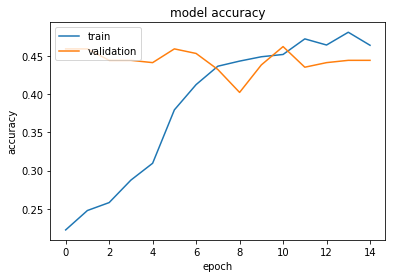

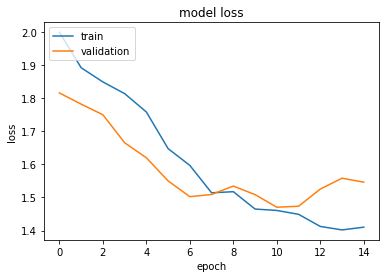

In [104]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

insights:
* the initial loss seems okay for -log(1/9)
* more hyperparameter tuning required
Key Problem is the imbalance in the set. The accuracy plot confirms this.
Simply put, Hard cases to learn, easy cases to predict.

TODO:
* Try some sort of Oversampling for minority classes

In [106]:
x = sentence_vectors.tolist

In [110]:
df_all['vecs']=list(sentence_vectors)

In [119]:
df_all['vecs'].head(5) #8989*100

0    [0.097663607387, -0.0259929845902, -0.00845325...
1    [0.176551141344, -0.0584905997037, -0.02040621...
2    [0.176551141344, -0.0584905997037, -0.02040621...
3    [0.155561588959, -0.0393181773901, -0.01467649...
4    [0.171830278738, -0.0230200448917, 0.005264781...
Name: vecs, dtype: object